In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Merge Data

In [2]:
def merge_and_deduplicate_data(file_paths, output_filename=None):
    """
    ฟังก์ชันสำหรับรวมไฟล์ CSV หลายไฟล์เข้าด้วยกันและตัดข้อมูลซ้ำโดยใช้ 'id'
    
    Args:
        file_paths (list): รายชื่อ path ของไฟล์ .csv ที่ต้องการรวม
                           เช่น ['data_part1.csv', 'data_part2.csv']
        output_filename (str, optional): ชื่อไฟล์ปลายทางถ้าต้องการบันทึกเป็น CSV ทันที
    
    Returns:
        pd.DataFrame: DataFrame ที่รวมและตัดตัวซ้ำเรียบร้อยแล้ว
    """
    
    all_dfs = []
    
    print(f"--- Starting Merge Process ---")
    
    # 1. วนลูปอ่านไฟล์แต่ละไฟล์ (Read CSVs)
    for file in file_paths:
        if os.path.exists(file):
            try:
                # อ่านไฟล์ CSV เข้ามาเป็น DataFrame
                df = pd.read_csv(file)
                all_dfs.append(df)
                print(f"[READ] {file}: Found {len(df)} rows")
            except Exception as e:
                print(f"[ERROR] Could not read {file}: {e}")
        else:
            print(f"[SKIP] File not found: {file}")
    
    if not all_dfs:
        print("No data loaded.")
        return pd.DataFrame()

    # 2. รวม DataFrame ทั้งหมดเข้าด้วยกัน (Concatenation)
    merged_df = pd.concat(all_dfs, ignore_index=True)
    total_rows_before = len(merged_df)
    
    # 3. ตัดข้อมูลซ้ำโดยดูจาก 'id' (Deduplication)
    # keep='last' หมายถึงถ้าเจอ id ซ้ำกัน ให้เก็บข้อมูลตัวล่าสุดไว้ (สมมติว่าเป็นข้อมูลที่อัปเดตกว่า)
    # subset=['id'] คือระบุว่าให้ดูความซ้ำกันที่คอลัมน์ id เท่านั้น
    cleaned_df = merged_df.drop_duplicates(subset=['id'], keep='last')
    
    total_rows_after = len(cleaned_df)
    duplicates_removed = total_rows_before - total_rows_after
    
    print(f"--- Merge Summary ---")
    print(f"Total rows raw: {total_rows_before}")
    print(f"Duplicates removed: {duplicates_removed}")
    print(f"Final unique rows: {total_rows_after}")
    
    # 4. รีเซ็ต index ให้เรียงสวยงาม 0, 1, 2, ...
    cleaned_df = cleaned_df.reset_index(drop=True)
    
    # 5. บันทึกไฟล์ถ้ามีการระบุชื่อไฟล์ (Export)
    if output_filename:
        cleaned_df.to_csv(output_filename, index=False, encoding='utf-8-sig')
        print(f"[SAVED] Merged data saved to: {output_filename}")
        
    return cleaned_df

## Log data

In [3]:
def log_data_stats(df, column_name):
    """
    ฟังก์ชันสำหรับวิเคราะห์สถิติและพล็อตกราฟ
    
    Args:
        df (pd.DataFrame): DataFrame หลัก
        column_name (str): ชื่อคอลัมน์ที่ต้องการวิเคราะห์ (Default: 'salary_amount')
    """
    
    print("\n" + "="*40)
    print(f"         STATISTICS LOG for '{column_name}'          ")
    print("="*40)
    
    # 1. เตรียมข้อมูล (Data Preparation)
    # แปลงเป็นตัวเลข (เผื่อเป็น string) และลบค่าว่าง (NaN) หรือค่า 0 ออกเพื่อความแม่นยำ
    if column_name not in df.columns:
        print(f"[ERROR] Column '{column_name}' not found.")
        return

    # coerce จะเปลี่ยน text ที่แปลงไม่ได้เป็น NaN
    data_numeric = pd.to_numeric(df[column_name], errors='coerce') 
    # กรองเอาเฉพาะที่มีค่าและมากกว่า 0 (บางที่ใส่ 0 หมายถึงไม่ระบุ)
    valid = data_numeric.dropna()
    valid = valid[valid > 0]
    
    if len(valid) == 0:
        print("No valid data found (all are NaN or 0).")
        return

    # 2. คำนวณสถิติ (Calculation)
    min = valid.min()
    max = valid.max()
    mean = valid.mean()
    
    # Mode อาจมีหลายค่าถ้าความถี่เท่ากัน
    modes = valid.mode()
    mode_str = ", ".join(map(str, modes.tolist()))
    
    # คำนวณ IQR (Interquartile Range)
    q1 = valid.quantile(0.25)
    q3 = valid.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # 3. แสดงผล Log (Logging)
    print(f"Count (Valid): {len(valid)} positions")
    print("-" * 40)
    print(f"Min   : {min:,.2f}")
    print(f"Max   : {max:,.2f}")
    print(f"Mean  : {mean:,.2f}")
    print(f"Mode  : {mode_str}")
    print("-" * 40)
    print("--- Variability (IQR) ---")
    print(f"Q1 (25%)     : {q1:,.2f}")
    print(f"Q3 (75%)     : {q3:,.2f}")
    print(f"IQR Value    : {iqr:,.2f}")
    print(f"Lower bound : Q1 - 1.5*IQR : {lower_bound:,.2f}")
    print(f"Upper bound : Q3 + 1.5*IQR : {upper_bound:,.2f}")
    print("="*40 + "\n")

    # 4. สร้างกราฟ (Visualization)
    # ตั้งค่า font ให้สวยงาม (ถ้ามีปัญหาภาษาไทยให้เอา font property ออกหรือเปลี่ยนเป็น Tahoma)
    plt.figure(figsize=(12, 5))
    
    # Subplot 1: Histogram + KDE (การกระจายตัว)
    plt.subplot(1, 2, 1)
    sns.histplot(valid, kde=True, color='skyblue', bins=20)
    plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.0f}')
    plt.axvline(valid.median(), color='green', linestyle='-', label=f'Median: {valid.median():.0f}')
    plt.title(f'Distribution of {column_name} Amount')
    plt.xlabel(f'{column_name} (THB)')
    plt.ylabel('Frequency')
    plt.legend()

    # Subplot 2: Boxplot (ดู IQR และ Outliers)
    plt.subplot(1, 2, 2)
    sns.boxplot(x=valid, color='lightgreen')
    plt.title(f'Boxplot of {column_name} (IQR & Outliers)')
    plt.xlabel(f'{column_name} (THB)')
    
    plt.tight_layout()
    plt.show()

## Main

In [12]:
# สมมติว่าเรามีไฟล์ csv 2 ไฟล์ที่ได้จากการ scrape
files_to_merge = [
    "cedt_intern_data_1000_2000.csv",  # ไฟล์จากวิธี loop ID
    "cedt_intern_data_paginated13.csv"   # ไฟล์จากวิธี pagination
]

# merge และ deduplicate ข้อมูล
df = merge_and_deduplicate_data(files_to_merge, "cedt_intern_all_merged.csv")

# create student_draft_ratio column
df['inStudentDraftCount'] = df['inStudentDraftCount'].fillna(0)
df['quota'] = df['quota'].fillna(1)  # เติม 1 เพื่อหลีกเลี่ยงการหารด้วยศูนย์
df['student_draft_ratio'] = df['inStudentDraftCount']/df['quota']

print("Salary type" + "*" *60)
print(df['salary_type'].value_counts())
mask = df['salary_type'].str.contains('บาท/เดือน', na=False, case=False) | df['salary_type'].str.contains('เหมาจ่าย', na=False, case=False)
df.loc[mask, 'salary_amount'] = df.loc[mask, 'salary_amount'] / 22
df.loc[mask, 'salary_amount'] = df.loc[mask, 'salary_amount'].round(0)

--- Starting Merge Process ---
[READ] cedt_intern_data_1000_2000.csv: Found 216 rows
[READ] cedt_intern_data_paginated13.csv: Found 260 rows
--- Merge Summary ---
Total rows raw: 476
Duplicates removed: 210
Final unique rows: 266
[SAVED] Merged data saved to: cedt_intern_all_merged.csv
Salary type************************************************************
salary_type
บาท/วัน           137
บาท/เดือน          23
ไม่มีค่าตอบแทน     18
บาท (เหมาจ่าย)      2
Name: count, dtype: int64


In [13]:
# df.head()
# df['work_type'].value_counts()
df.describe(include="all")

,id,company_name,position_title,quota,salary_amount,salary_type,work_type,location,tags,description_html,api_url,company_nameTh,company_nameEn,Start Date,End Date,inStudentDraftCount,student_draft_ratio
count,266.000000,6,266,266.000000,170.000000,180,241,266,234,261,266,260,260,115,115,266.000000,266.000000
unique,NaN,6,223,NaN,NaN,4,3,86,223,258,19,99,99,17,13,NaN,NaN
top,NaN,บริษัท บล็อคฟินท์ จำกัด,Data Engineer,NaN,NaN,บาท/วัน,Hybrid,สำนักงานใหญ่,"Data Analyst, SQL, Advance Excel, Data Visuali...",<h2><strong>About the Project</strong></h2><p>...,https://cedtintern.cp.eng.chula.ac.th/api/sess...,บริษัท ช้อปปี้ (ประเทศไทย) จำกัด,"Shopee (Thailand) Co., Ltd.",2026-04-30T17:00:00.000Z,2026-07-30T17:00:00.000Z,NaN,NaN
freq,NaN,1,8,NaN,NaN,137,126,69,4,3,20,14,14,34,66,NaN,NaN
mean,1346.236842,NaN,NaN,2.330827,339.358824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.060150,2.470909
std,157.566279,NaN,NaN,2.583611,151.972847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.982626,3.085126
min,1039.000000,NaN,NaN,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,1214.250000,NaN,NaN,1.000000,250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
50%,1352.000000,NaN,NaN,1.000000,400.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,1.138095
75%,1477.500000,NaN,NaN,3.000000,455.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,3.500000


Position Title Counts:************************************************************
position_title
Data Engineer                                  8
Software Developer                             6
Business Analyst                               6
Software Engineer                              6
Full Stack Developer                           6
                                              ..
Software Business Analyst (Product Manager)    1
Fullstack developer                            1
Data science                                   1
Engineering Data Analyst                       1
Developer Intern                               1
Name: count, Length: 223, dtype: int64
Ratio Student Draft:************************************************************
describe :  count    266.000000
mean       2.470909
std        3.085126
min        0.000000
25%        0.000000
50%        1.138095
75%        3.500000
max       17.000000
Name: student_draft_ratio, dtype: float64
sum of student draft ratio : 

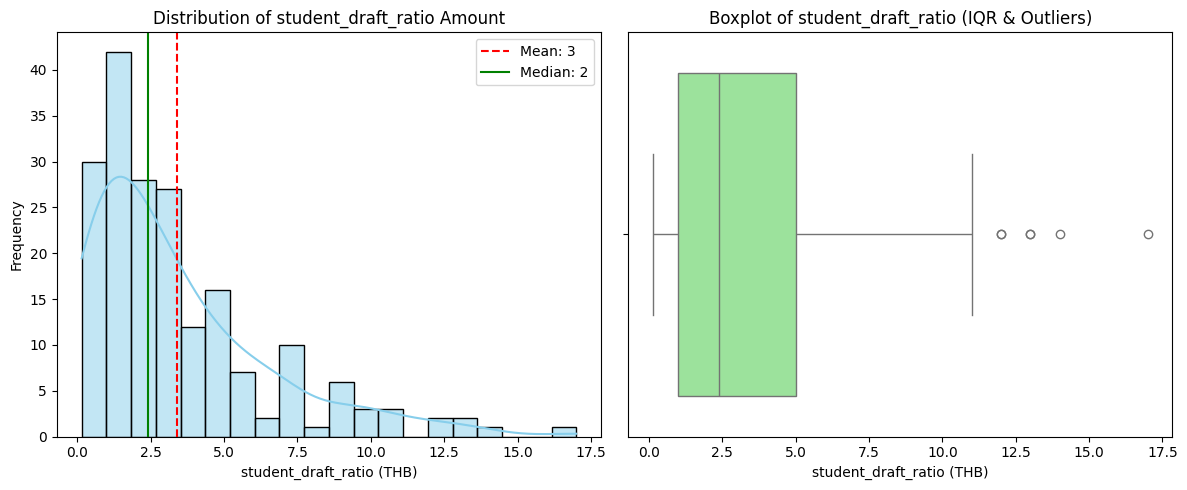

Salary:************************************************************

         STATISTICS LOG for 'salary_amount'          
Count (Valid): 157 positions
----------------------------------------
Min   : 100.00
Max   : 600.00
Mean  : 367.46
Mode  : 400.0
----------------------------------------
--- Variability (IQR) ---
Q1 (25%)     : 300.00
Q3 (75%)     : 455.00
IQR Value    : 155.00
Lower bound : Q1 - 1.5*IQR : 67.50
Upper bound : Q3 + 1.5*IQR : 687.50



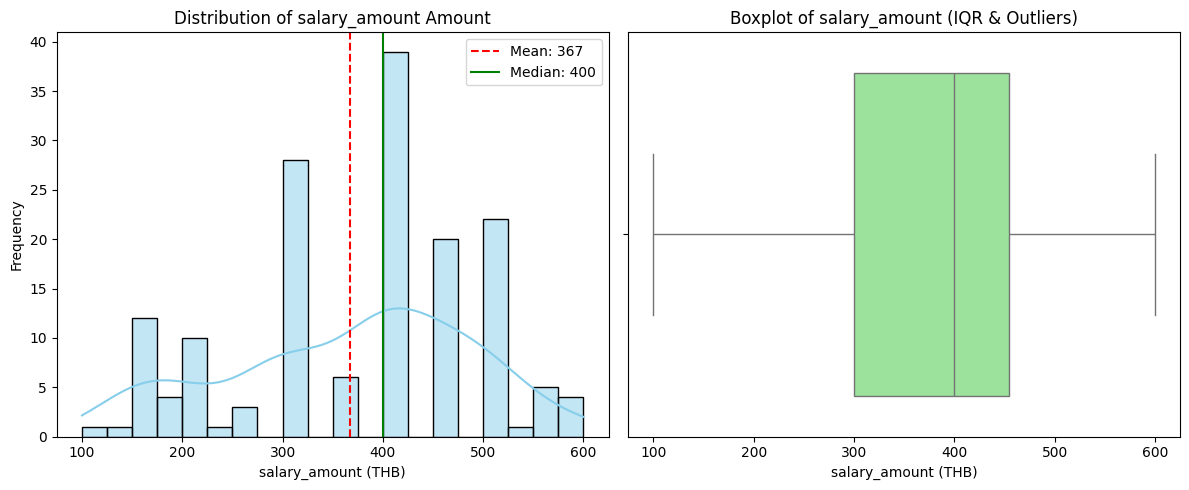

Work Type:************************************************************


work_type
Hybrid            126
On-Site            98
Work From Home     17
Name: count, dtype: int64

In [14]:
print("Position Title Counts:" + "*" *60)
print(df['position_title'].value_counts())
print("Ratio Student Draft:" + "*" *60)
print("describe : ", df["student_draft_ratio"].describe())
print("sum of student draft ratio : ", df["student_draft_ratio"].sum())
log_data_stats(df, column_name='student_draft_ratio')
print("Salary:" + "*" *60)
log_data_stats(df, column_name='salary_amount')
print("Work Type:" + "*" *60)
df['work_type'].value_counts()

In [20]:
mask = (df['student_draft_ratio'] <= 2.0) & \
       (df['salary_amount'] >= 150.0) & (df['salary_amount'] <= 400.0) & \
       (df['work_type'] != 'Work From Home')

filtered_df = df[mask]
print(filtered_df.shape[0], "/", df.shape[0])

listNamePosition = filtered_df['id'].tolist()
print(listNamePosition)

import csv

# Save
with open('listNamePosition.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(listNamePosition)  # or writerows() for multiple rows

65 / 266
[1201, 1606, 1609, 1619, 1039, 1043, 1055, 1093, 1127, 1128, 1129, 1150, 1152, 1188, 1190, 1214, 1222, 1231, 1251, 1268, 1271, 1276, 1331, 1332, 1370, 1378, 1383, 1388, 1390, 1391, 1396, 1399, 1427, 1431, 1453, 1454, 1455, 1456, 1476, 1480, 1481, 1484, 1487, 1509, 1510, 1526, 1529, 1536, 1538, 1539, 1543, 1544, 1545, 1549, 1564, 1566, 1567, 1568, 1572, 1573, 1574, 1575, 1587, 1589, 1600]
